In [2]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader # for dataloaders 
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors 
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model
from efficientnet_pytorch import EfficientNet
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from efficientnet_pytorch import EfficientNet
from torchvision.datasets import ImageFolder
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
%matplotlib inline

In [3]:
#Loading the dataset 
data_dir = 'D:/project_cardomom/Cardamom_disease_dataset(Augmented)'
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"
diseases = os.listdir(train_dir)


In [4]:
# printing the disease names
print(diseases)

['Cardamom___Healthy', 'Cardamom___LeafBlight', 'Cardamom___LeafSpot']


In [5]:
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
    if plant.split('___')[1] != 'healthy':
        NumberOfDiseases += 1

In [6]:
# Details of unique catogories plants in the dataset
print(f"Unique Plants are: \n{plants}")

Unique Plants are: 
['Cardamom']


In [7]:
# number of unique plants
print("Number of plants: {}".format(len(plants)))
# number of unique diseases
print("Number of diseases: {}".format(NumberOfDiseases))

Number of plants: 1
Number of diseases: 3


In [8]:
import torchvision.datasets as datasets
import pandas as pd

# Directory paths containing your image datasets
data_dirs = [
    'D:/project_cardomom/Cardamom_disease_dataset(Augmented)/train/Cardamom___Healthy',
    'D:/project_cardomom/Cardamom_disease_dataset(Augmented)/train/Cardamom___LeafBlight',
    'D:/project_cardomom/Cardamom_disease_dataset(Augmented)/train/Cardamom___LeafSpot'
]

class_names = [
    'Cardamom___Healthy',
    'Cardamom___LeafBlight',
    'Cardamom___LeafSpot'
]

img_per_class = {}

# Count the number of images per class
for class_name, data_dir in zip(class_names, data_dirs):
    dataset = datasets.ImageFolder(data_dir)
    num_images = len(dataset)
    img_per_class[class_name] = num_images

# Create a DataFrame to display the results
img_per_class_df = pd.DataFrame({"No. of Images": img_per_class})
print(img_per_class_df)



                       No. of Images
Cardamom___Healthy               722
Cardamom___LeafBlight            603
Cardamom___LeafSpot              643


In [9]:
# datasets for validation and training
train = ImageFolder(train_dir, transform=transforms.ToTensor())
valid = ImageFolder(valid_dir, transform=transforms.ToTensor()) 

In [10]:
img, label = train[0]
print(img.shape, label)

torch.Size([3, 320, 320]) 0


In [11]:
# total number of classes in train set
len(train.classes)

3

In [12]:
# for checking some images from training dataset
def show_image(image, label):
    print("Label :" + train.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))

Label :Cardamom___Healthy(0)


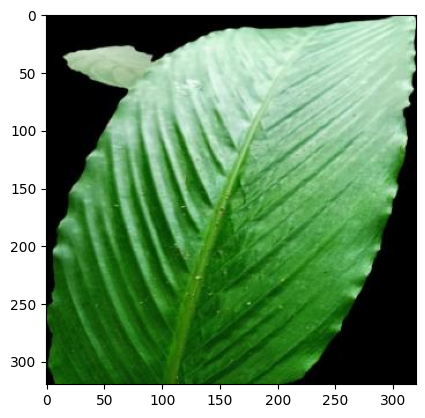

In [13]:
show_image(*train[1])

In [14]:
# Setting the seed value
random_seed = 7
random_seed=torch.manual_seed(random_seed)

In [15]:
#setting batch_size
batch_size = 8

In [16]:
# DataLoaders for training and validation
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid, batch_size, num_workers=2, pin_memory=True)

In [17]:
# helper function to show a batch of training instances
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

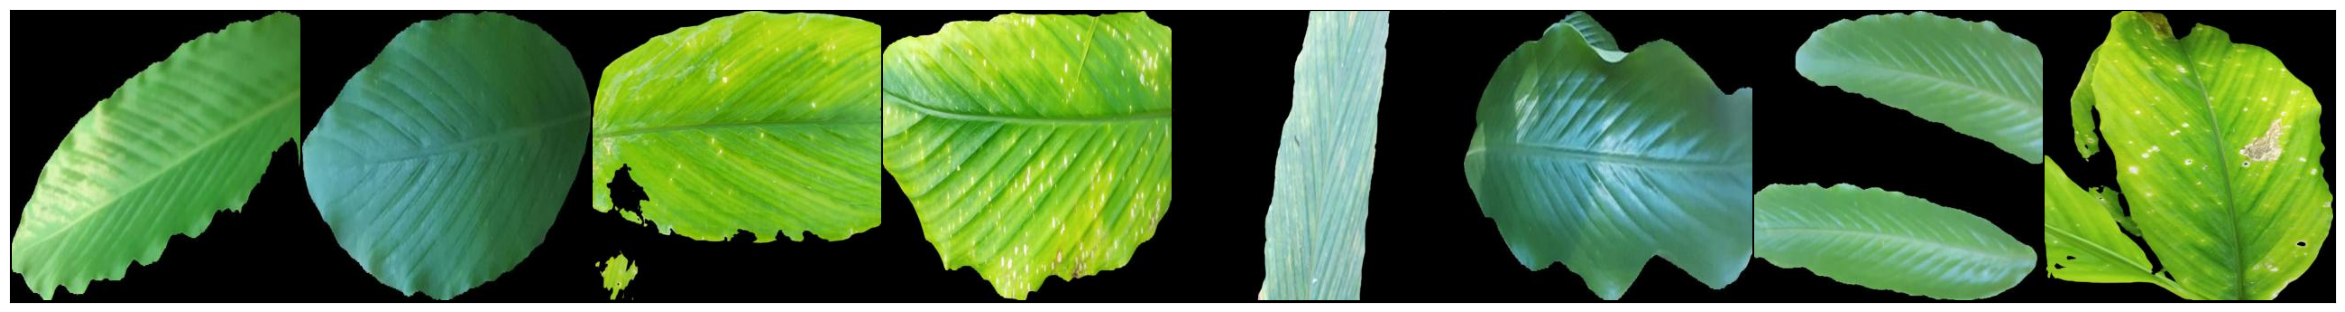

In [18]:
# Images for first batch of training
show_batch(train_dl) 

In [19]:
# for moving data into GPU (if available)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [20]:
#Setting the device
device = get_default_device()
device

device(type='cuda')

In [21]:
# Moving data into GPU
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [22]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

In [23]:
# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# base class for the model
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate prediction
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)          # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss  
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))
        

In [24]:
# Architecture for training

# convolution block with BatchNormalization
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


# resnet architecture 
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases):
        super().__init__()
        
        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True) # out_dim : 128 x 64 x 64 
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))
        
        self.conv3 = ConvBlock(128, 256, pool=True) # out_dim : 256 x 16 x 16
        self.conv4 = ConvBlock(256, 512, pool=True) # out_dim : 512 x 4 x 44
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                    nn.Flatten(),
                                    nn.Linear(512, num_diseases))
        
    def forward(self, xb): # xb is the loaded batch
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out        

In [25]:
model = to_device(ResNet9(3, len(train.classes)), device) 

In [26]:
# getting summary of the model
INPUT_SHAPE = (3, 224, 224)
print(summary(model.cuda(), (INPUT_SHAPE)))

RuntimeError: Given input size: (512x3x3). Calculated output size: (512x0x0). Output size is too small

In [ ]:
# for training
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    

def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0,
                grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # scheduler for one cycle learniing rate
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            optimizer.zero_grad()
            
            # recording and updating learning rates
            lrs.append(get_lr(optimizer))
            sched.step()
            
    
        # validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history
    

In [ ]:
history = [evaluate(model, valid_dl)]

In [ ]:
epochs = 50
max_lr = 0.1
grad_clip = 1
weight_decay = 1e-6
opt_func = torch.optim.RMSprop

In [176]:
%%time
history += fit_OneCycle(epochs, max_lr, model, train_dl, valid_dl, 
                            grad_clip=grad_clip, 
                            weight_decay=weight_decay, 
                            opt_func=opt_func)

Epoch [0], last_lr: 0.00504, train_loss: 6.8147, val_loss: 1.5129, val_acc: 0.7896
Epoch [1], last_lr: 0.00814, train_loss: 6.5691, val_loss: 24.9039, val_acc: 0.4583
Epoch [2], last_lr: 0.01315, train_loss: 12.0775, val_loss: 31.6308, val_acc: 0.7363
Epoch [3], last_lr: 0.01986, train_loss: 27.1997, val_loss: 583768.8125, val_acc: 0.3267
Epoch [4], last_lr: 0.02798, train_loss: 98.4630, val_loss: 330050.0938, val_acc: 0.3064
Epoch [5], last_lr: 0.03714, train_loss: 111.5842, val_loss: 523.1056, val_acc: 0.5208
Epoch [6], last_lr: 0.04696, train_loss: 337.4887, val_loss: 1496.9406, val_acc: 0.6032
Epoch [7], last_lr: 0.05700, train_loss: 402.8271, val_loss: 464.4328, val_acc: 0.7536
Epoch [8], last_lr: 0.06682, train_loss: 437.2291, val_loss: 173.4987, val_acc: 0.8130
Epoch [9], last_lr: 0.07599, train_loss: 375.1105, val_loss: 4766.8760, val_acc: 0.4060
Epoch [10], last_lr: 0.08411, train_loss: 359.2132, val_loss: 785.1948, val_acc: 0.6672
Epoch [11], last_lr: 0.09083, train_loss: 360

In [218]:
def plot_accuracies(history):
    accuracies = [x['val_accuracy'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'].cpu().numpy() for x in history]  # Move tensors to CPU and convert to numpy arrays

    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

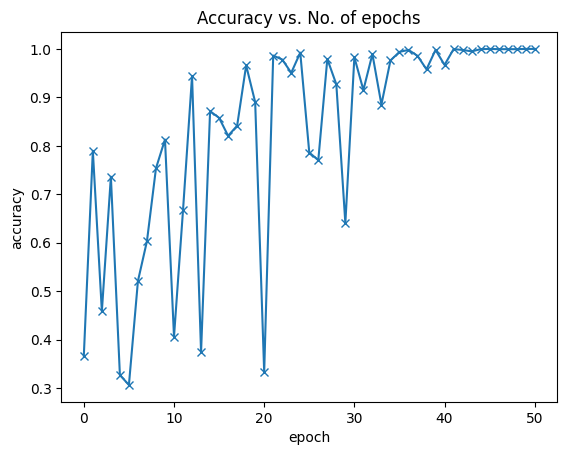

In [178]:
plot_accuracies(history)

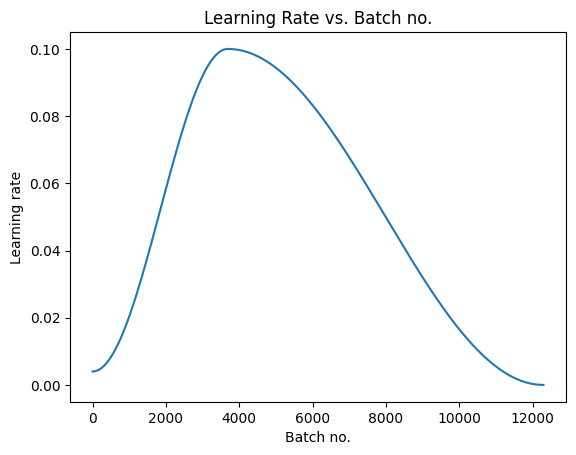

In [179]:
plot_lrs(history)

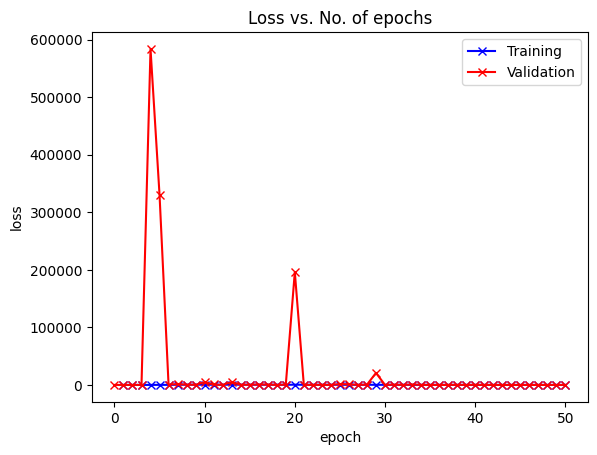

In [180]:
plot_losses(history)

In [219]:
test_dir = "D:/project_cardomom/Test_images"
test = ImageFolder(test_dir, transform=transforms.ToTensor())

In [220]:
test_images = sorted(os.listdir(f'{test_dir}/test'))
test_images

['Cardmom_HL_1.jpg',
 'Cardmom_HL_2.jpg',
 'Cardmom_HL_3.jpg',
 'Cardmom_HL_4.jpg',
 'Cardmom_HL_5.jpg',
 'Cardmom_HL_6.jpg',
 'Cardmom_HL_7.jpg',
 'Leaf_blight_1.JPG',
 'Leaf_blight_3.JPG',
 'Leaf_blight_4.JPG',
 'Leaf_blight_5.JPG',
 'Leaf_blight_6.JPG',
 'Leaf_blight_8.JPG',
 'leaf_spot_1.jpg',
 'leaf_spot_2.jpg',
 'leaf_spot_3.jpg',
 'leaf_spot_4.jpg',
 'leaf_spot_5.jpg',
 'leaf_spot_6.jpg',
 'leaf_spot_7.jpg',
 'leaf_spot_8.jpg']

In [221]:
def predict_image(img, model):
    """Converts image to array and return the predicted class
        with highest probability and the confidence score"""
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Move xb to the same device as the model
    xb = xb.to(next(model.parameters()).device)
    # Get predictions from model
    yb = model(xb)
    # Compute probabilities from logits
    probabilities = torch.softmax(yb, dim=1)
    # Get the predicted class index
    _, preds = torch.max(probabilities, dim=1)
    # Get the confidence score for the predicted class
    confidence = probabilities[0, preds.item()].item()
    # Retrieve the class label
    predicted_class = train.classes[preds.item()]
    
    return predicted_class, confidence


Label: Cardmom_HL_5.jpg , Predicted: Cardamom___LeafBlight , Confidence: 0.6603202223777771


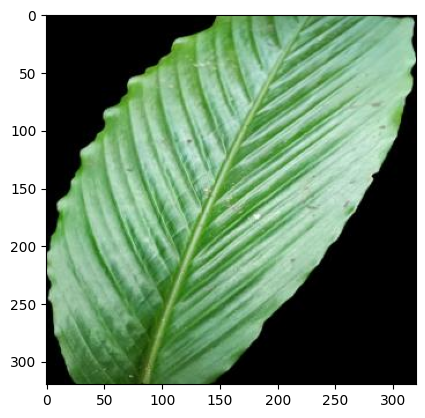

In [222]:
# predicting first image
img, label = test[4]
plt.imshow(img.permute(1, 2, 0))
predicted_class, confidence = predict_image(img, model)
print('Label:', test_images[4], ', Predicted:', predicted_class, ', Confidence:', confidence)

In [185]:
#trained_model=model
#torch.save(trained_model.state_dict(), 'my_Res_cardamom_update.pt')

In [223]:
loaded_model =model
loaded_model.load_state_dict(torch.load('my_Res_cardamom_update.pt'))

<All keys matched successfully>

In [226]:
for i, (img, label) in enumerate(test):
    print('Label:', test_images[i], ', Predicted:', predict_image(img, model))
#Ouput on training time

Label: Cardmom_HL_1.jpg , Predicted: ('Cardamom___Healthy', 0.9999979734420776)
Label: Cardmom_HL_2.jpg , Predicted: ('Cardamom___Healthy', 1.0)
Label: Cardmom_HL_3.jpg , Predicted: ('Cardamom___Healthy', 0.9999998807907104)
Label: Cardmom_HL_4.jpg , Predicted: ('Cardamom___Healthy', 1.0)
Label: Cardmom_HL_5.jpg , Predicted: ('Cardamom___Healthy', 1.0)
Label: Cardmom_HL_6.jpg , Predicted: ('Cardamom___Healthy', 1.0)
Label: Cardmom_HL_7.jpg , Predicted: ('Cardamom___Healthy', 1.0)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x1024 and 512x3)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x1024 and 512x3)

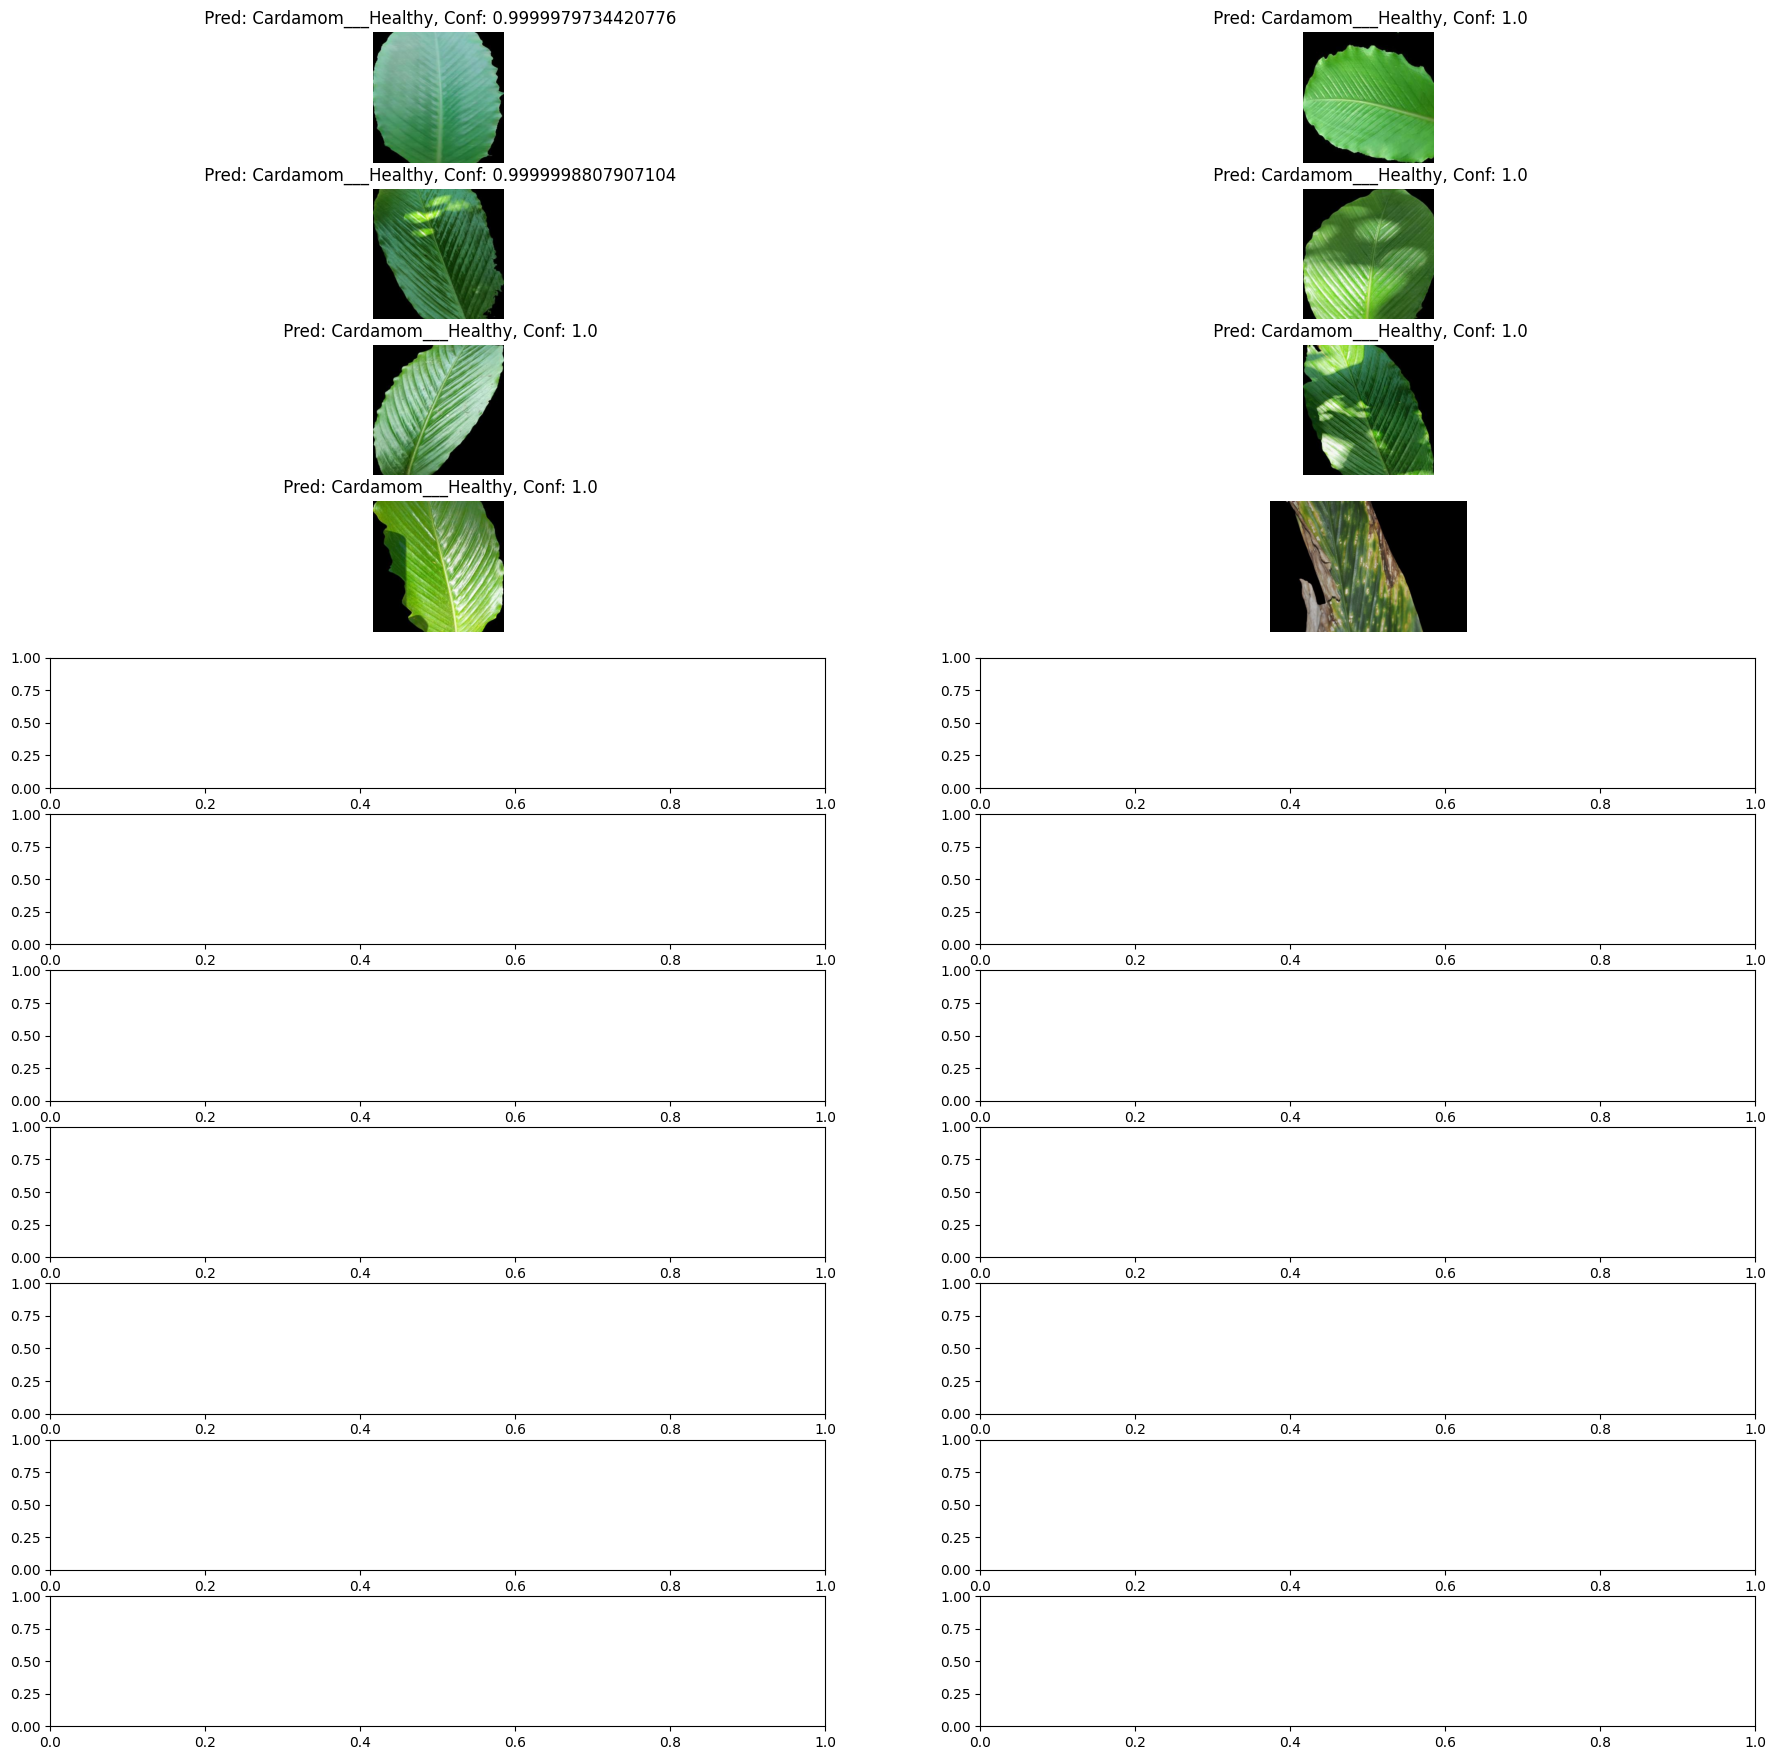

In [78]:
import math

# Calculate the number of rows and columns for the subplot grid
num_images = len(test)
rows = math.ceil(num_images / 2)
cols = min(num_images, 2)

# Create a subplot grid
fig, axs = plt.subplots(rows, cols, figsize=(22, 22))
axs = axs.flatten()

# Iterate over test dataset
for i, (img, label) in enumerate(test):
    # Display image
    axs[i].imshow(img.permute(1, 2, 0))
    axs[i].axis('off')

    # Get predicted class and confidence
    predicted_class, confidence = predict_image(img, model)
    axs[i].set_title(f" Pred: {predicted_class}, Conf: {confidence}")

    # Break loop if all subplots are filled
    if i+1 >= rows * cols:
        break

# Adjust spacing between subplots

plt.subplots_adjust(wspace=.01, hspace=.5)
# Show the plot
plt.show()
